sorce: https://towardsdatascience.com/building-my-neural-network-from-scratch-cbb97321cb8f
### Create a Neural Network Class
A basic neural network consists of the following parts:
* An input layer
* An output layer
* One or more hidden layers
* Weights between each layer
* Activation functions
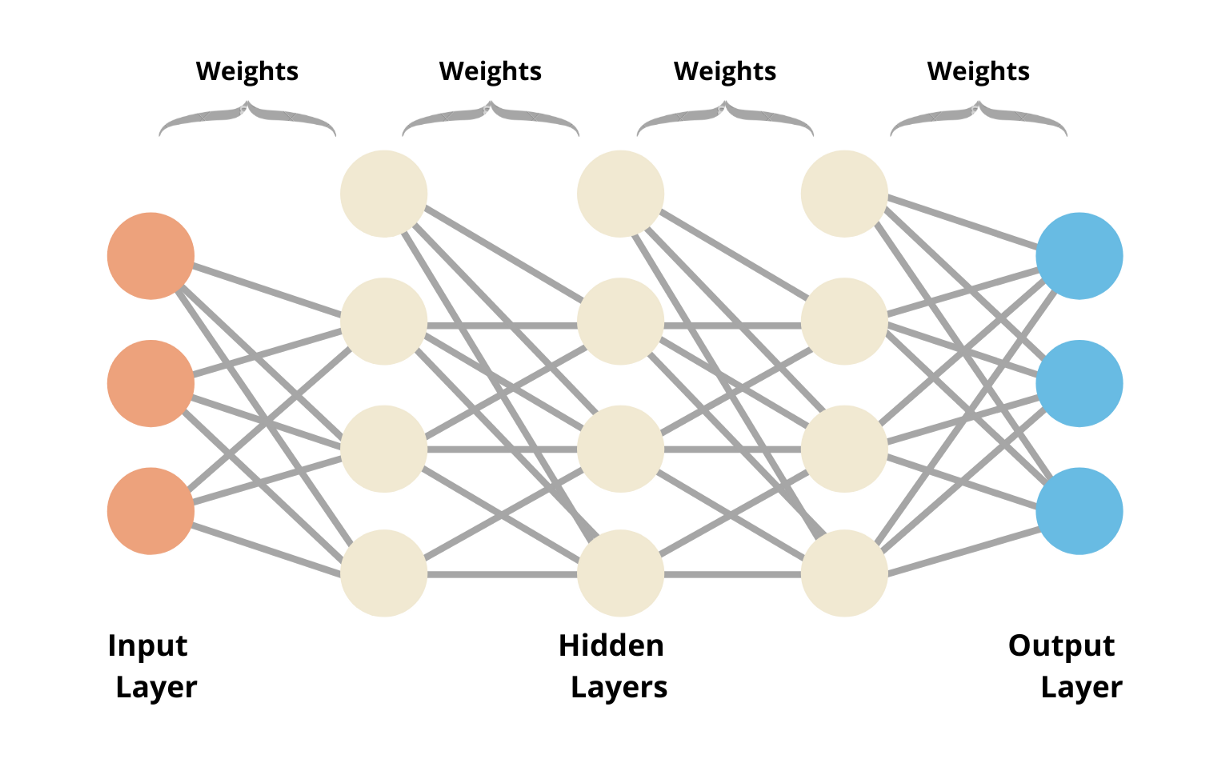
Note that:
* The number of nodes in the input layer is the same as the number of features of the input, and the number of classes of output gives the number of nodes in the output layer.
* A bias unit is added to each layer except the output layer.
* There are several types of activation functions. Here I use a sigmoid function for every layer of my neural network.
* So let’s create a neural network class in python:

In [12]:
# %load sigmoid.py
import numpy as np
from scipy.optimize import minimize
from sigmoid import sigmoid, sigmoid_grad


class NeuralNetwork:
    '''

    My neural network


    Args:
        total_lyrs (int): The number of layers of the neural network
                          Input layer and output layer ARE counted
        total_nodes (list): The number of nodes in each hidden layer
                            Bias unit is NOT counted
        rglr_param (float): Regulariztion parameter


    Attributes:
        total_lyrs (int): The number of layers of the neural network
                          Input layer and output layer ARE counted
        total_nodes (list): The number of nodes in each layer
                            Nums of nodes for input and output are set to 0 at first
                            Bias unit is NOT counted
        rglr_param (float): Regulariztion parameter
    '''

    def __init__(self, total_lyrs, total_nodes, rglr_param):
        self.total_lyrs = total_lyrs
        self.total_nodes = np.array([0] + total_nodes + [0])
        self.rglr_param = rglr_param
        
    def rand_init_weights(self):
        '''Initialize weight parameter randomly


        Returns:
            init_weights (1darray): An unrolled initial weight parameter for each layer
        '''

        def init_epsilon(nodes_in, nodes_out):
            return np.sqrt(6) / np.sqrt(nodes_in + nodes_out)

        # Randomly initialize weight between an suitable interval for each layer
        init_weights = np.array([])
        for nodes_in, nodes_out in list(zip(self.total_nodes[:-1],
                                            self.total_nodes[1:])):
            epsilon = init_epsilon(nodes_in, nodes_out)
            rand_weight = (2 * epsilon * (np.random.random(nodes_out * (nodes_in + 1)))
                           - epsilon)
            init_weights = np.concatenate((init_weights, rand_weight))

        return init_weights


    def reshape_weights(self, weights_unrolled):
        '''Reshape an unrolled weight parameter into a list of weights


        Args:
            weights_unrolled (1darray): The unrolled weight to be reshaped


        Returns:
            weights (list): A list that consists of weight for each layer
        '''

        weights = []
        for nodes_in, nodes_out in list(zip(self.total_nodes[:-1],
                                            self.total_nodes[1:])):
            weight = np.reshape(weights_unrolled[:nodes_out * (nodes_in + 1)],
                                (nodes_out, nodes_in + 1))
            weights.append(weight)
            weights_unrolled = np.delete(weights_unrolled,
                                         np.s_[:nodes_out * (nodes_in + 1)])
        return weights

### Model Representation
Given m training examples (X, Y), we write them into matrices:
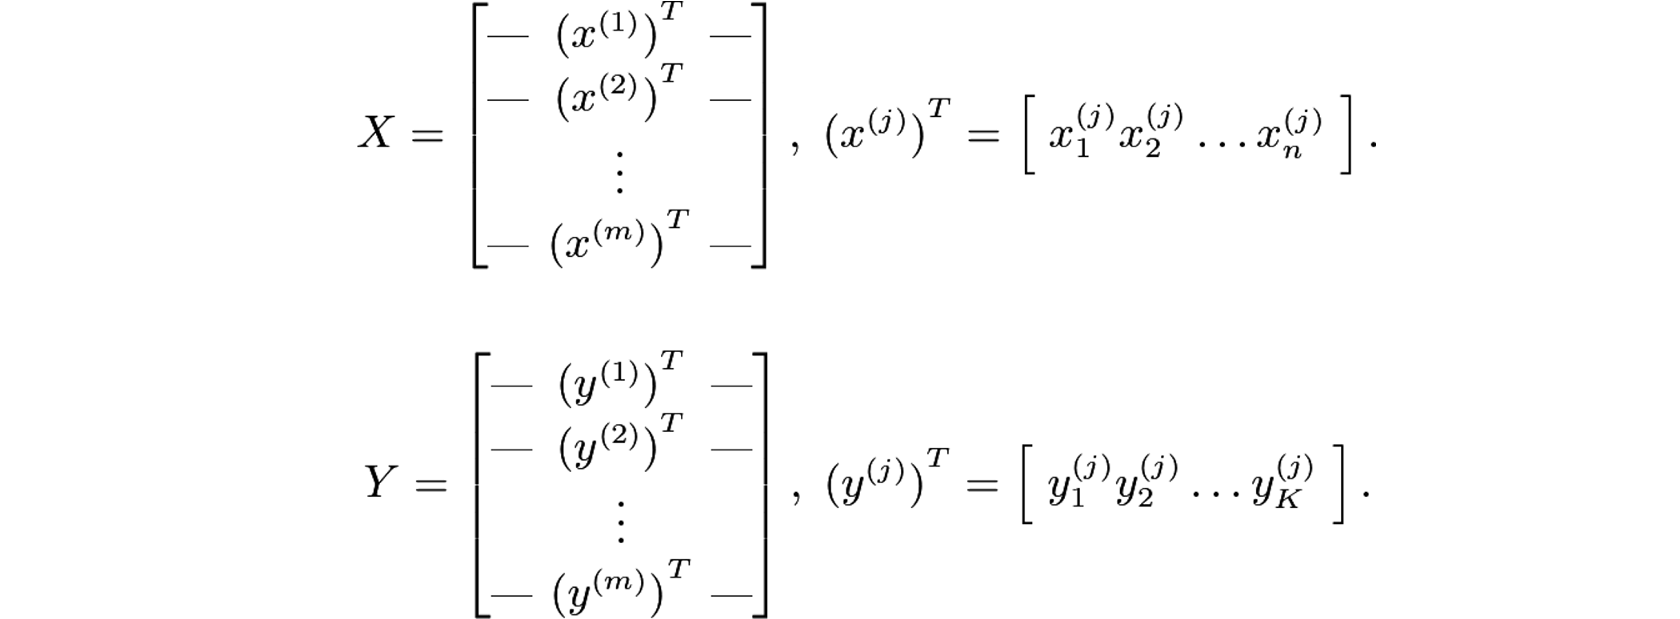
where every row of X is one training example of n features, and every row of Y represents which of the K classes each example is in.

We represent every layer l of an L-layer neural network as the following:
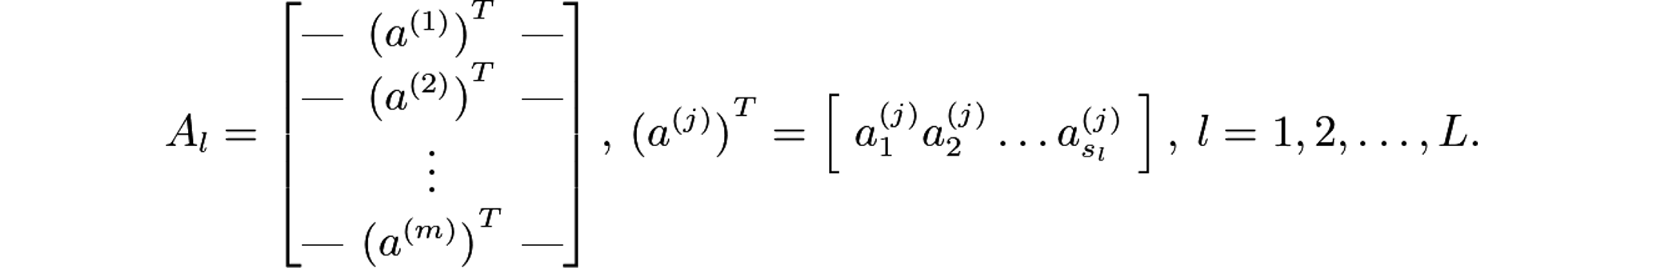

The j-th row of each matrix denotes the value of the j-th example in that layer. Here Sl represents the number of nodes in l-th layer.
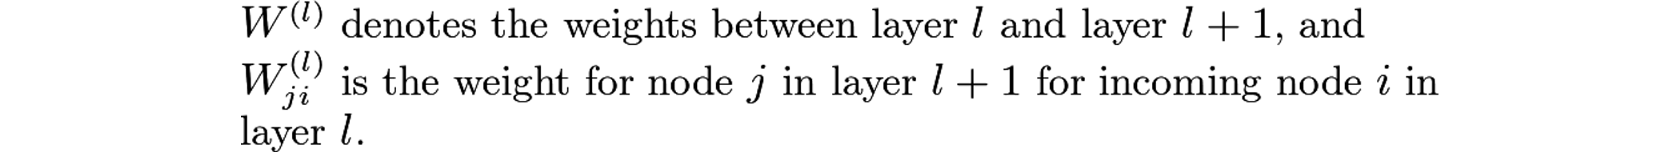

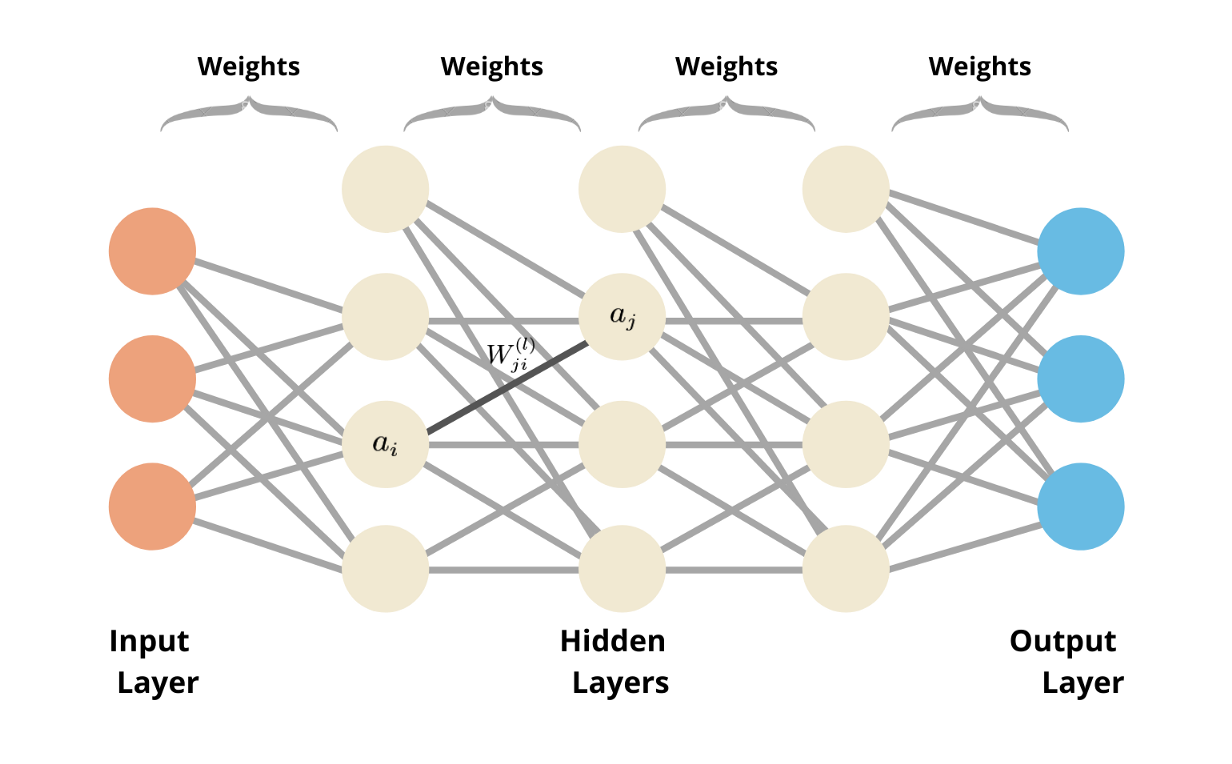

### Feedforward Computation
We use feedforward computation to compute the predicted output given input and weights.

Given input X, we first compute the value of the first hidden layer.

First, add a bias term to the input layer. And then multiply the input layer by the weight matrix to get
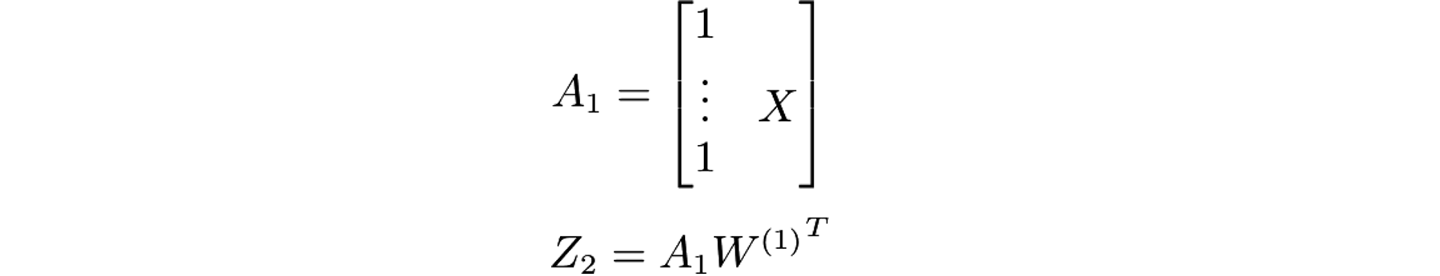

Apply the activation function to get the matrix A for the first layer:
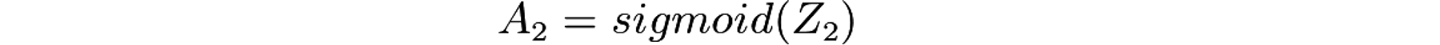

Now we just repeat this procedure to compute the value for each layer, including the output layer.
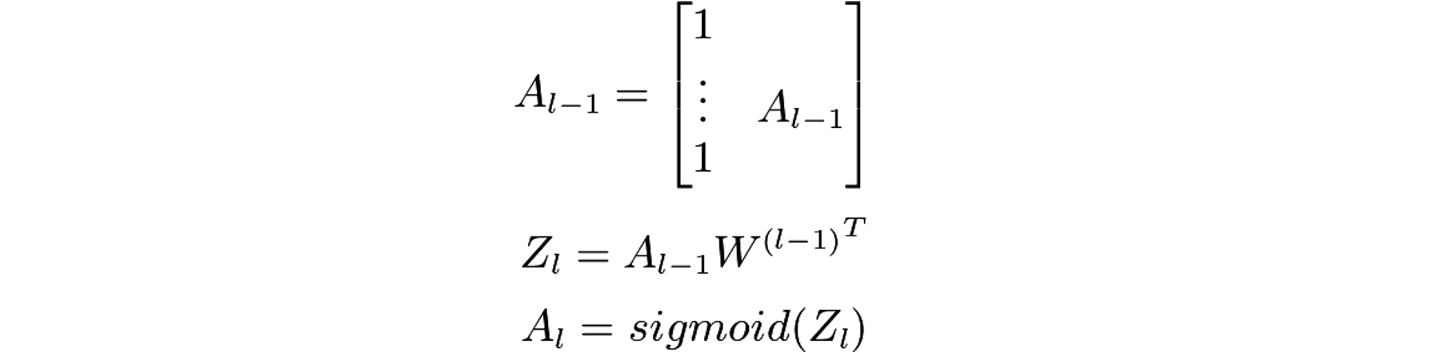

In [13]:
def feedforward(self, X, weights):
    '''Feedforward computation


    Args:
        X (2darray): An mxn array representing m inputs with n features
        weights (list): A list that consists of weight for each layer


    Returns:
        node_z (list): A list that consists of node's value for each layer
        node_a (list): A list that consists of activated node's value for each layer
                       Note that bias term is appended to each a except the output layer
    '''

    node_z = [X]
    node_a = [X]
    for weight in weights:
        node_a[-1] = np.insert(node_a[-1], 0, 1, axis=1)
        # node_z.append(node_a[-1] @ weight.T)
        node_z.append(np.matmul(node_a[-1], weight.T))
        node_a.append(sigmoid(node_z[-1]))
    return node_z, node_a
NeuralNetwork.feedforward = feedforward

### Cost Function
The cost function for the neural network with regularization is given by :
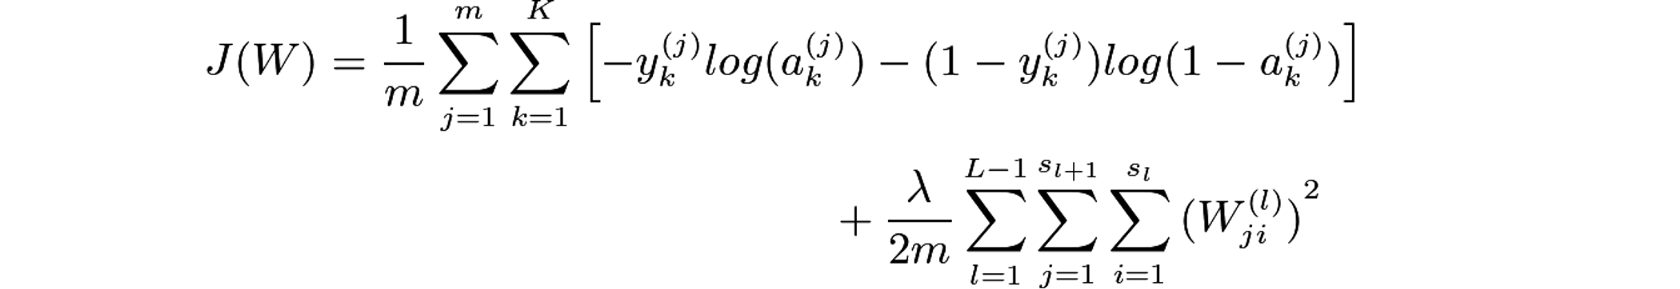
Here a is the value from the output layer, and λ denotes the regularization parameter.

Our goal is to find a good set weight parameters to minimize the cost function. We can use several optimization algorithms such as gradient descent to minimize the function. To apply the algorithm, we have to compute the gradient for the cost function.

In [14]:
def cost(self, pred_y, y, weights):
    '''Compute the cost function


    Args:
        pred_y (2darray): The predicted output
        y (2darray): The actual training output
        weights (list): A list that consists of weight for each layer


    Returns:
        cost (float): The cost function
    '''

    m = y.shape[0]
    cost = sum(np.einsum('ij,ij->i', -y, np.log(pred_y))
               - np.einsum('ij,ij->i', 1 - y, np.log(1 - pred_y)))
    cost += (self.rglr_param / 2
             * sum([np.sum(weight[:, 1:] ** 2) for weight in weights]))
    cost /= m
    return cost
NeuralNetwork.cost = cost

### Backpropagation
We implement the backpropagation algorithm to compute the gradient for the cost function.
Ref: https://medium.com/@b06201018/how-backpropagation-works-d1bac48ca90
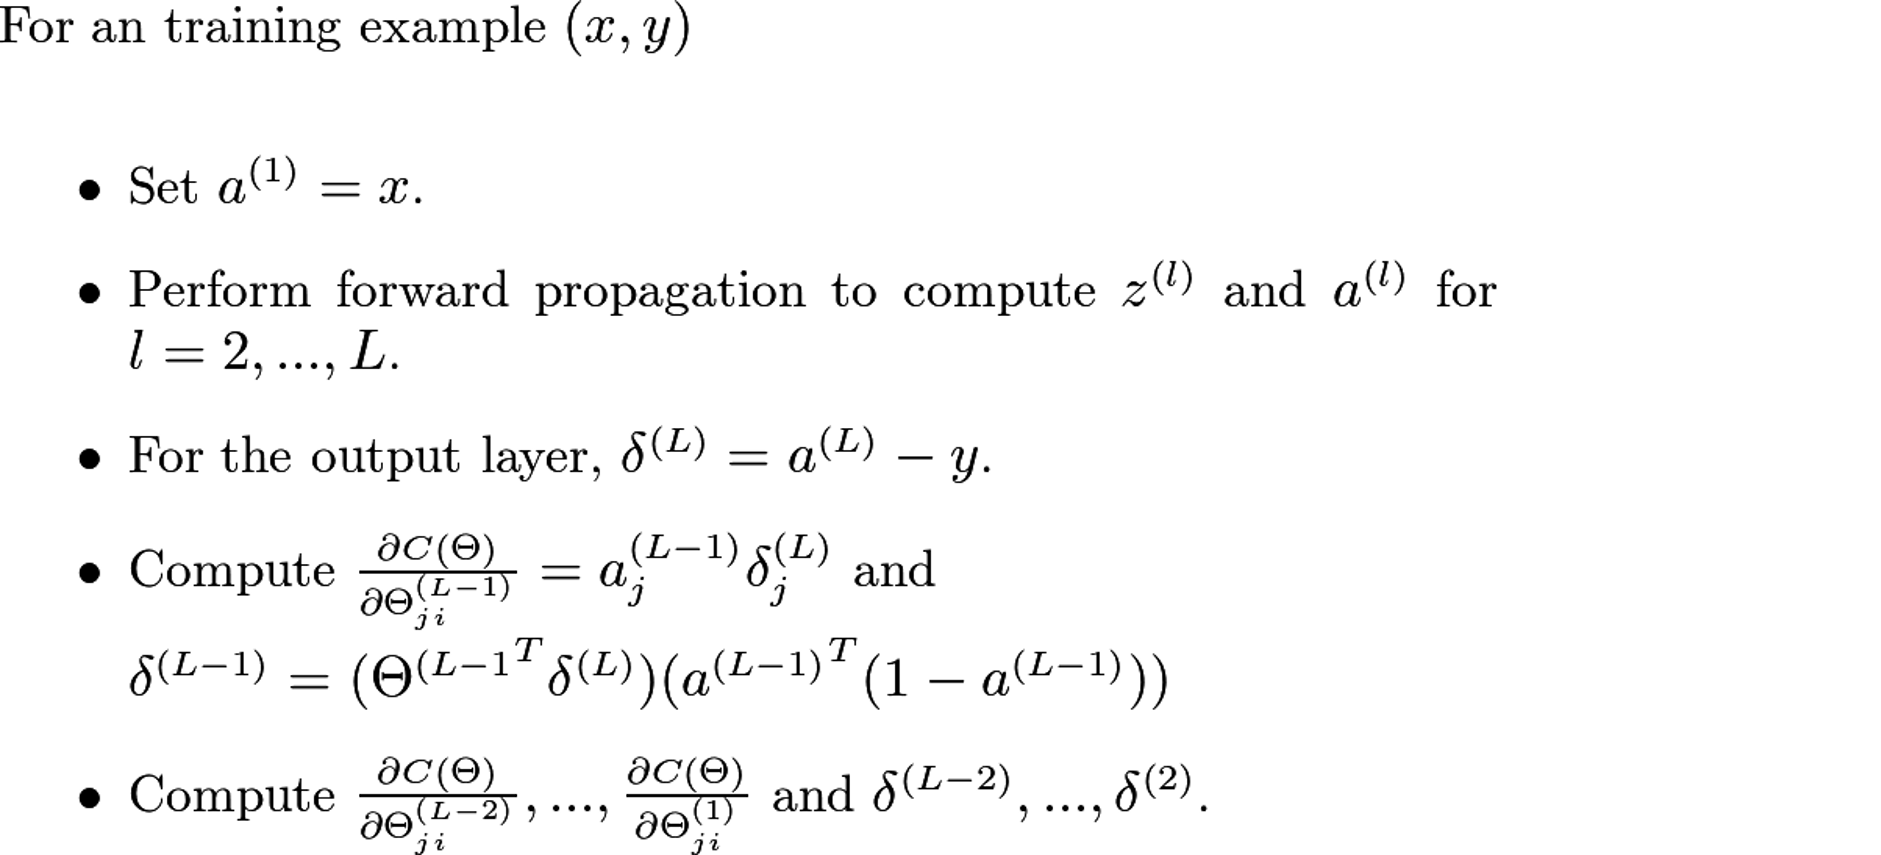

In [15]:
def backprop(self, weights, X, y):
    '''Backpropagation algorithm to compute the gradient for the cost function


    Args:
        weights (1darray): An unrolled weight parameter that consists of weight for each layer
        X (2darray): An mxn array representing m training inputs with n features
        y (2darray): An mxK array representing m training outputs in K classes


    Returns:
        cost (float): The cost function
        grad_unrolled (1darray): An unrolled gradient for the cost function
    '''

    m = y.shape[0]
    weights = self.reshape_weights(weights)

    # Feedforward computaion
    node_z, node_a = self.feedforward(X, weights)

    # Cost function
    cost = self.cost(node_a[-1], y, weights)

    # Compute the gradient
    delta = [node_a[-1] - y]
    delta[-1] = np.insert(delta[-1], 0, 1, axis=1)
    node_a.pop()
    node_z.pop()
    grads = []
    while weights:
        # grads.append(delta[-1][:, 1:].T @ node_a[-1])
        grads.append(np.matmul(delta[-1][:, 1:].T,node_a[-1]))
        grads[-1][:, 1:] += self.rglr_param * weights[-1][:, 1:]
        node_z[-1] = np.insert(node_z[-1], 0, 1, axis=1)
        # delta.append((delta[-1][:, 1:] @ weights[-1])
        #              * sigmoid_grad(node_z[-1]))
        delta.append(np.matmul(delta[-1][:, 1:],weights[-1])
                     * sigmoid_grad(node_z[-1]))
        node_a.pop()
        node_z.pop()
        weights.pop()

    # Unroll the list of gradients into 1darray
    grad_unrolled = np.array([])
    for grad in reversed(grads):
        grad_unrolled = np.concatenate((grad_unrolled,
                                        np.ravel(grad)))

    # Finish the computaion of the gradient
    grad_unrolled /= m

    return cost, grad_unrolled
NeuralNetwork.backprop = backprop

### Learning Parameters
After we have implemented the cost function and gradient computation, we use SciPy’s minimize function to learn a good set parameters that minimizes the cost function.
### Training the Neural Network
Let’s put everything together to train our neural network:

In [16]:
def train(self, X, y):
    '''Train the neural network based on test data


    Args:
        X (2darray): An mxn array representing m training inputs with n features
        y (2darray): An mxK array representing m training outputs in K classes


    Returns:
        Trained_weights (list): A good set weights that minimizes the cost function
    '''

    self.total_nodes[0] = X.shape[1]
    self.total_nodes[-1] = y.shape[1]

    # Initialize weights
    init_weights = self.rand_init_weights()

    # Find weights that minimize the cost function
    min_result = minimize(fun=self.backprop, x0=init_weights, args=(X, y),
                          method='TNC', jac=True, options={'maxiter': 3000})
    trained_weights = self.reshape_weights(min_result.x)
    return trained_weights
NeuralNetwork.train = train

### Prediction
Now we can use our trained neural network to predict the label of a test data set. To do so just implement the feedfoward computation to compute the output Y for the test data X.

In [17]:
def predict(self, weights, X):
    '''Predict the output label for test input data


    Args:
        weights (list): A list that consists of trained weight for each layer
        X (2darray): An mxn array representing m test inputs with n features


    Returns:
        pred_y (2darray): The predicted output
    '''

    node_z, node_a = self.feedforward(X, weights)
    pred_y = node_a[-1]
    return pred_y
NeuralNetwork.predict = predict

In [20]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.io import loadmat

data = loadmat('data\ex3data1.mat')

X = data['X']
y = data['y']

encoder = OneHotEncoder(sparse=False)  #Normalización de los datos
y_encoded = encoder.fit_transform(y)

nn = NeuralNetwork(3, [25], 1)
weights = nn.train(X, y_encoded)
pred_y = nn.predict(weights, X)
pred_y = np.argmax(pred_y, axis=1) + 1


correct = [1 if a == b else 0 for (a, b) in zip(pred_y, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))


C:\Users\gallastegi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


accuracy = 99.58%


# Implementación con scikit-learn
* ANN - MLP: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
* k-NN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
* Decision Tree: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [21]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(25), max_iter=300)
mlp.fit(X, y_encoded)
pred_y = mlp.predict(X)
pred_y = np.argmax(pred_y, axis=1) + 1

correct = [1 if a == b else 0 for (a, b) in zip(pred_y, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.72%


C:\Users\gallastegi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

pred_y = neigh.predict(X)
# pred_y = np.argmax(pred_y, axis=1) + 1

correct = [1 if a == b else 0 for (a, b) in zip(pred_y, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

C:\Users\gallastegi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


accuracy = 97.6%


In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X,y)
pred_y = dtc.predict(X)
correct = [1 if a == b else 0 for (a, b) in zip(pred_y, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 100.0%


# Ejercicio: Realiza una comparación de estos tres paradigmas de clasificación con los datos de este ejercicio, intentando realizando un mejor ajuste de los parámetros con Random o GridSearch.

### GridSearch
##### La intencion es optimizar los parametros de los clasificadores: 
##### MLP ->  hidden_layer_sizes y max_iter
##### k-NN -> n_neighbors
##### Decision Tree -> random_state

In [24]:
# Paremetros y librerias
import numpy.random as nr
import sklearn.model_selection as ms
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)

In [ ]:
#MLP
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"hidden_layer_sizes": [25, 50, 75, 100, 150, 200], "max_iter": [100, 200, 300, 400, 500]}

## Define the Classifier
mlp = MLPClassifier()

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = mlp, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'accuracy',
                      return_train_score = True,n_jobs=-1)

## Fit thhe cross validated grid search over the data 
clf.fit(X, y)
keys = list(clf.cv_results_.keys())
for key in keys[6:16]:
    print(clf.cv_results_[key])
## And print the best parameter value
print(clf.best_estimator_.hidden_layer_sizes)
print(clf.best_estimator_.max_iter)

In [ ]:
#k-NN
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"n_neighbors": [2, 3, 5, 6, 7, 8, 9, 10]}

## Define the Classifier
neigh = KNeighborsClassifier()

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = neigh, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'accuracy',
                      return_train_score = True,n_jobs=-1)

## Fit thhe cross validated grid search over the data 
clf.fit(X, y)
keys = list(clf.cv_results_.keys())
for key in keys[6:16]:
    print(clf.cv_results_[key])
## And print the best parameter value
print(clf.best_estimator_.n_neighbors)

In [ ]:
#Decision Tree
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"random_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]}

## Define the Classifier
dtc = DecisionTreeClassifier()

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = dtc, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'accuracy',
                      return_train_score = True,n_jobs=-1)

## Fit thhe cross validated grid search over the data 
clf.fit(X, y)
keys = list(clf.cv_results_.keys())
for key in keys[6:16]:
    print(clf.cv_results_[key])
## And print the best parameter value
print(clf.best_estimator_.random_state)